# Testing Linear Regression Assumptions

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import statsmodels.graphics.tsaplots as tsa
import glob
import os
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
import statsmodels.formula.api

## Data Processing

In [ ]:
# setting the path for joining multiple files
files = os.path.join("", "content/*.csv")

# list of merged files returned
files = glob.glob(files)

# joining files with concat and read_csv
df = pd.concat(map(pd.read_csv, files), ignore_index=True).drop(
    ['Appellation', 'Bottle Size', 'Description', 'User Avg Rating', 'Name', 'Importer',
     'Designation', 'Unnamed: 0', 'Reviewer'], 
    axis=1
).dropna()

# clean up
df['Price'] = (df['Price'].str[1:].str.replace(',','')).astype(float)
df['Alcohol'] = (df['Alcohol'].str.replace('%','')).astype(float)
df['Date Published'] =  pd.to_datetime(df['Date Published'])
df = df[df['Vintage'] >= 1995]
df = df[(df.Province != 'LimarÃ Valley') & (df.Province != 'CuricaÃ³ Valley')]

# removing outliers for quantitative data
# price
highest = df['Price'].mean() + 3*df['Price'].std()
lowest = df['Price'].mean() - 3*df['Price'].std()
df = df[(df['Price'] < highest) & (df['Price'] > lowest)]
# alcohol percentage
highest = df['Alcohol'].mean() + 3*df['Alcohol'].std()
lowest = df['Alcohol'].mean() - 3*df['Alcohol'].std()
df = df[(df['Alcohol'] < highest) & (df['Alcohol'] > lowest)]
# vintage
highest = df['Vintage'].mean() + 3*df['Vintage'].std()
lowest = df['Vintage'].mean() - 3*df['Vintage'].std()
df = df[(df['Vintage'] < highest) & (df['Vintage'] > lowest)]


print(df.dtypes)
df.to_csv('wine_data.csv') 
df = df.reset_index(drop=True)
df

Alcohol                           float64
Category                           object
Country                            object
Date Published             datetime64[ns]
Price                             float64
Province                           object
Rating                            float64
Region                             object
Reviewer Twitter Handle            object
Subregion                          object
Variety                            object
Vintage                           float64
Winery                             object
dtype: object


,Alcohol,Category,Country,Date Published,Price,Province,Rating,Region,Reviewer Twitter Handle,Subregion,Variety,Vintage,Winery
0,14.5,Red,US,2019-06-01,42.0,California,92.0,Central Coast,@mattkettmann,Santa Maria Valley,"Gamay Noir, Gamay",2016.0,Stasis
1,13.5,Red,US,2019-04-01,36.0,Oregon,92.0,Willamette Valley,@paulgwine,Ribbon Ridge,"Gamay Noir, Gamay",2017.0,Brick House
2,13.5,Red,US,2019-04-01,29.0,Oregon,91.0,Willamette Valley,@paulgwine,Ribbon Ridge,"Gamay Noir, Gamay",2017.0,Brick House
3,12.5,Rose,US,2019-04-01,18.0,Oregon,90.0,Southern Oregon,@paulgwine,Elkton Oregon,"Gamay Noir, Gamay",2017.0,Lexème
4,14.1,Red,US,2019-03-01,40.0,California,94.0,Central Coast,@mattkettmann,Santa Barbara County,"Gamay Noir, Gamay",2016.0,Martian Ranch
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41056,15.5,Red,US,2009-12-31,25.0,Oregon,88.0,Southern Oregon,@paulgwine,Umpqua Valley,Tempranillo,2007.0,Abacela
41057,13.5,Red,US,2009-12-31,25.0,Oregon,87.0,Southern Oregon,@paulgwine,Umpqua Valley,Tempranillo,2007.0,Abacela
41058,14.1,Red,US,2009-12-31,20.0,Oregon,86.0,Southern Oregon,@paulgwine,Southern Oregon,Tempranillo,2007.0,Abacela
41059,14.4,Red,US,2009-04-01,35.0,Oregon,91.0,Southern Oregon,@paulgwine,Southern Oregon,Tempranillo,2006.0,Abacela


,Vintage,Alcohol,Price,Rating
0,2008.0,14.597357,32.396429,87.417857
1,2009.0,14.427952,32.247672,87.551210
2,2010.0,14.353597,37.057751,88.315096
3,2011.0,14.143891,40.884558,88.554422
4,2012.0,14.309155,43.008288,89.305004
5,2013.0,14.287281,40.092214,89.470655
6,2014.0,14.276013,41.105692,89.725058
7,2015.0,14.207001,40.709463,90.030560
8,2016.0,14.055957,35.372104,89.587478
9,2017.0,13.719476,25.426230,88.674084


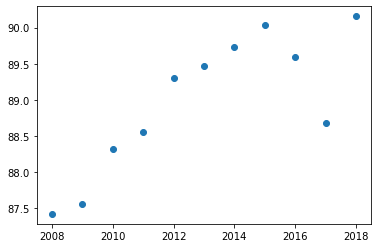

In [ ]:
napa = df[df['Province'] == ' California']
napa = napa.groupby(by=['Vintage'], as_index=False).mean()
napa = (napa[(napa['Vintage'] >= 2008) & (napa['Vintage'] <= 2018)]).reset_index(drop=True)
plt.scatter(napa['Vintage'], napa['Rating'])
napa

The sum of the squared errors is:  2.052563312800834


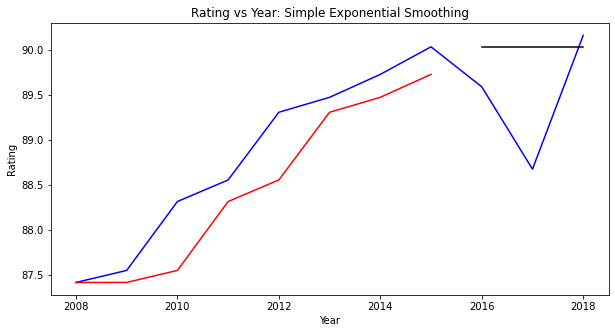

In [ ]:
train = napa[(napa['Vintage'] < 2016)]
test = napa[(napa['Vintage'] >= 2016)]
fit1 = SimpleExpSmoothing(train['Rating']).fit()
fore1 = fit1.forecast(len(test['Vintage']))
plt.figure(figsize=(10,5))
plt.plot(napa['Vintage'], napa['Rating'], color = 'blue')
plt.plot(train['Vintage'], fit1.fittedvalues, color = 'red')
plt.plot(test['Vintage'], fore1, color = 'black')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating vs Year: Simple Exponential Smoothing')
sse = (fore1-test['Rating']).pow(2).sum()
print("The sum of the squared errors is: ", sse)

The sum of the squared errors is:  11127673.058675969


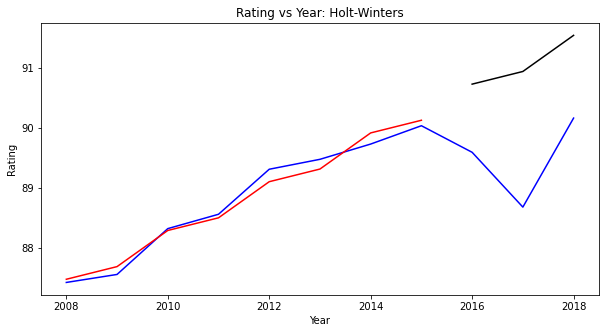

In [ ]:
fit2 = ExponentialSmoothing(train['Rating'], trend='add', seasonal="add", seasonal_periods = 2).fit()
fore2 = fit2.forecast(len(test['Vintage']))
plt.figure(figsize=(10,5))
plt.plot(napa['Vintage'], napa['Rating'], color = 'blue')
plt.plot(train['Vintage'], fit2.fittedvalues, color = 'red')
plt.plot(test['Vintage'], fore2, color = 'black')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating vs Year: Holt-Winters')
sse = (fore2-test['Vintage']).pow(2).sum()
print("The sum of the squared errors is: ", sse)

In [ ]:
weather = pd.read_csv('napaweather.csv').drop(['Station', 'obs'], axis=1)
weather['Precip'] = (weather['Precip'].str.replace(',','.')).astype(float) * 16.3871
weather['Air max'] = (weather['Air max'] - 32) * (5/9)
weather['min'] = (weather['min'] - 32) * (5/9)
weather['Diff'] = weather['Air max'] - weather['min']
weather['Avg'] = (weather['Air max'] + weather['min'])/2
weather['Date'] = (pd.to_datetime(weather['Date'].astype(str), format='%Y%m%d')).dt.strftime('%m-%d-%Y')
weather['Year'] = (pd.DatetimeIndex(weather['Date']).year).astype(float)
weather = weather[(weather['Year'] >= 2008) & (weather['Year'] <= 2018)]
weather['Month'] = (pd.DatetimeIndex(weather['Date']).month).astype(float)
weather = weather.drop(['Air max', 'min'], axis=1)
weather = weather.groupby(by=['Year', 'Month'], as_index=False).mean()
precip = weather[weather['Month'] <= 3]
temps = weather[weather['Month'] >= 10]

precip = precip.groupby(by=['Year'], as_index=False).mean()
precip = precip[['Year', 'Precip']]
temps = temps.groupby(by=['Year'], as_index=False).mean()
temps = temps[['Diff', 'Avg']]
temps['Avg2'] = temps['Avg']**2
features = pd.concat([precip, temps, napa['Rating']], axis=1)
features

,Year,Precip,Diff,Avg,Avg2,Rating
0,2008.0,2.482248,13.083632,13.131621,172.439467,87.417857
1,2009.0,2.143664,12.601951,12.088511,146.132087,87.551210
2,2010.0,2.859184,11.333931,13.067603,170.762236,88.315096
3,2011.0,2.314143,15.761250,11.028176,121.620666,88.554422
4,2012.0,1.958371,13.582636,12.065711,145.581379,89.305004
5,2013.0,0.281740,17.778375,10.535344,110.993483,89.470655
6,2014.0,1.836501,14.281163,13.586420,184.590802,89.725058
7,2015.0,0.515527,15.224811,12.124154,146.995104,90.030560
8,2016.0,1.663622,13.468937,11.696037,136.797292,89.587478
9,2017.0,3.620014,17.249303,11.775787,138.669149,88.674084


The sum of the squared errors is:  1.3793586094680874


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     1.142
Date:                Sun, 15 May 2022   Prob (F-statistic):              0.476
Time:                        23:51:04   Log-Likelihood:                -7.0239
No. Observations:                   8   AIC:                             24.05
Df Residuals:                       3   BIC:                             24.44
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.2572     93.211      0.561      0.614    -244.383     348.898
Precip        -0.5367      0.745     -0.720      0.524      -2.909       1.835
Diff           0.3371      0.553      0.609      0.585      -1.424       2.098
Avg            4.8767     13.956      0.349      0.750     -39.536      49.290
Avg2          -0.1788      0.561     -0.319      0.771      -1.964       1.606
==============================================================================
Omnibus:                        1.365   Durbin-Watson:                   1.205
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                0.774
Skew:                          -0.688   Prob(JB):                        0.679
Kurtosis:                       2.348   Cond. No.                     4.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

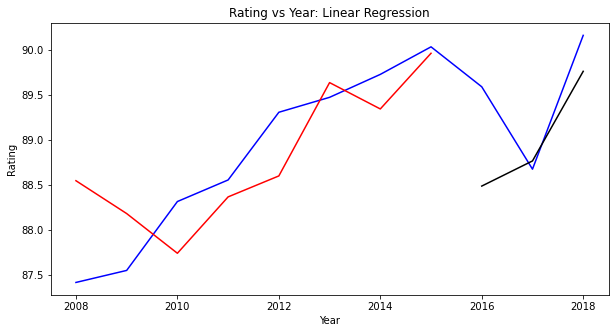

In [ ]:
train = features[(features['Year'] < 2016)]
test = features[(features['Year'] >= 2016)]
fit3 = statsmodels.formula.api.ols('Rating ~ Precip + Diff + Avg + Avg2', train).fit()
fore3 = fit3.predict(test)
plt.figure(figsize=(10,5))
plt.plot(features['Year'], features['Rating'], color = 'blue')
plt.plot(train['Year'], fit3.fittedvalues, color = 'red')
plt.plot(test['Year'], fore3, color = 'black')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Rating vs Year: Linear Regression')
sse = (fore3-test['Rating']).pow(2).sum()
print("The sum of the squared errors is: ", sse)
fit3.summary()

## Analysis

### Group By Twitter Handle

,Price,Alcohol,Rating,Vintage,logPrice,Reviewer Twitter Handle_@apatrone23,Reviewer Twitter Handle_@gordone_cellars,Reviewer Twitter Handle_@laurbuzz,Reviewer Twitter Handle_@mattkettmann,Reviewer Twitter Handle_@paulgwine,Reviewer Twitter Handle_@paulgwineÂ,Reviewer Twitter Handle_@suskostrzewa,Reviewer Twitter Handle_@vboone,Reviewer Twitter Handle_@vossroger,Reviewer Twitter Handle_@wawinereport
0,12.0,11.600000,87.000000,2016.000000,2.484907,1,0,0,0,0,0,0,0,0,0
1,13.0,12.400000,85.500000,2016.500000,2.564949,1,0,0,0,0,0,0,0,0,0
2,14.0,12.020000,86.400000,2016.600000,2.639057,1,0,0,0,0,0,0,0,0,0
3,15.0,12.366667,86.583333,2016.208333,2.708050,1,0,0,0,0,0,0,0,0,0
4,16.0,12.259259,86.851852,2016.037037,2.772589,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,107.0,14.400000,85.000000,2012.000000,4.672829,0,0,0,0,0,0,0,0,0,1
620,110.0,14.600000,92.000000,2014.500000,4.700480,0,0,0,0,0,0,0,0,0,1
621,115.0,13.725000,95.000000,2011.500000,4.744932,0,0,0,0,0,0,0,0,0,1
622,120.0,13.545455,94.090909,2012.727273,4.787492,0,0,0,0,0,0,0,0,0,1


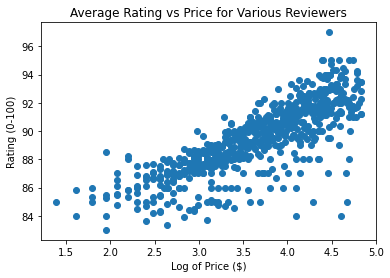

In [ ]:
reviewers = df.groupby(by=['Reviewer Twitter Handle', 'Price'], as_index=False).mean()
reviewers['logPrice'] = np.log(reviewers['Price'])
reviewers = pd.get_dummies(reviewers)
plt.scatter(reviewers['logPrice'], reviewers['Rating'])
plt.ylabel('Rating (0-100)')
plt.xlabel('Log of Price ($)')
plt.title('Average Rating vs Price for Various Reviewers')
reviewers

Text(0.5, 1.0, 'Average Rating vs Price for Various Reviewers')

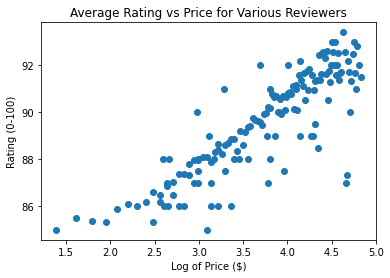

In [ ]:
price = df.groupby(by=['Price'], as_index=False).mean()
price['logPrice'] = np.log(price['Price'])
plt.scatter(price['logPrice'], price['Rating'])
plt.ylabel('Rating (0-100)')
plt.xlabel('Log of Price ($)')
plt.title('Average Rating vs Price for Various Reviewers')

### Reviewer Models

In [ ]:
Y = reviewers['Rating']
X = reviewers.loc[:, ~reviewers.columns.isin(['Rating', 'Alcohol', 'Vintage', 'Price'])]
X = sm.add_constant(X) 

model = sm.OLS(Y, X)
results = model.fit()

# Print out the stats
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     201.2
Date:                Sun, 15 May 2022   Prob (F-statistic):          3.32e-186
Time:                        12:09:14   Log-Likelihood:                -1010.9
No. Observations:                 624   AIC:                             2044.
Df Residuals:                     613   BIC:                             2093.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       72.0268      0.262    275.061      0.000      71.513      72.541
logPrice                                     2.6357      0.071     37.012      0.000       2.496       2.776
Reviewer Twitter Handle_@apatrone23          7.2346      0.233     31.083      0.000       6.777       7.692
Reviewer Twitter Handle_@gordone_cellars     8.5690      0.177     48.302      0.000       8.221       8.917
Reviewer Twitter Handle_@laurbuzz            6.1448      0.334     18.375      0.000       5.488       6.802
Reviewer Twitter Handle_@mattkettmann        8.0568      0.159     50.637      0.000       7.744       8.369
Reviewer Twitter Handle_@paulgwine           8.4242      0.175     48.199      0.000       8.081       8.767
Reviewer Twitter Handle_@paulgwineÂ          8.9110      0.198     44.999      0.000       8.522       9.300
Reviewer Twitter Handle_@suskostrzewa        4.5971      0.235     19.528      0.000       4.135       5.059
Reviewer Twitter Handle_@vboone              7.5212      0.171     44.021      0.000       7.186       7.857
Reviewer Twitter Handle_@vossroger           5.1819      1.124      4.609      0.000       2.974       7.390
Reviewer Twitter Handle_@wawinereport        7.3862      0.176     41.889      0.000       7.040       7.732
==============================================================================
Omnibus:                      169.157   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              758.542
Skew:                          -1.155   Prob(JB):                    1.93e-165
Kurtosis:                       7.882   Cond. No.                     2.36e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.68e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
Y = reviewers['Rating']
X = reviewers[['logPrice', 'Reviewer Twitter Handle_@apatrone23']]
X = sm.add_constant(X) 

apatrone23 = sm.OLS(Y, X).fit()

# Print out the stats
apatrone23.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     535.5
Date:                Sun, 15 May 2022   Prob (F-statistic):          6.99e-136
Time:                        12:09:14   Log-Likelihood:                -1152.0
No. Observations:                 624   AIC:                             2310.
Df Residuals:                     621   BIC:                             2323.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  79.3962      0.321    247.551      0.000      78.766      80.026
logPrice                                2.7636      0.086     32.224      0.000       2.595       2.932
Reviewer Twitter Handle_@apatrone23    -0.5560      0.281     -1.981      0.048      -1.107      -0.005
==============================================================================
Omnibus:                      141.812   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.472
Skew:                          -1.110   Prob(JB):                     6.63e-88
Kurtosis:                       6.242   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = reviewers['Rating']
X = reviewers[['logPrice', 'Reviewer Twitter Handle_@gordone_cellars']]
X = sm.add_constant(X) 

gordone_cellars = sm.OLS(Y, X).fit()

# Print out the stats
gordone_cellars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     562.2
Date:                Sun, 15 May 2022   Prob (F-statistic):          4.50e-140
Time:                        12:09:14   Log-Likelihood:                -1142.3
No. Observations:                 624   AIC:                             2291.
Df Residuals:                     621   BIC:                             2304.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       79.1499      0.313    252.588      0.000      78.535      79.765
logPrice                                     2.7923      0.084     33.279      0.000       2.628       2.957
Reviewer Twitter Handle_@gordone_cellars     0.8813      0.181      4.863      0.000       0.525       1.237
==============================================================================
Omnibus:                      143.094   Durbin-Watson:                   1.304
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              427.520
Skew:                          -1.100   Prob(JB):                     1.46e-93
Kurtosis:                       6.406   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = reviewers['Rating']
X = reviewers[['logPrice', 'Reviewer Twitter Handle_@laurbuzz']]
X = sm.add_constant(X) 

laurbuzz = sm.OLS(Y, X).fit()

# Print out the stats
laurbuzz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     549.1
Date:                Sun, 15 May 2022   Prob (F-statistic):          4.87e-138
Time:                        12:09:14   Log-Likelihood:                -1147.0
No. Observations:                 624   AIC:                             2300.
Df Residuals:                     621   BIC:                             2313.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                79.5195      0.320    248.622      0.000      78.891      80.148
logPrice                              2.7312      0.086     31.889      0.000       2.563       2.899
Reviewer Twitter Handle_@laurbuzz    -1.6200      0.433     -3.742      0.000      -2.470      -0.770
==============================================================================
Omnibus:                      144.955   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              429.747
Skew:                          -1.117   Prob(JB):                     4.80e-94
Kurtosis:                       6.396   Cond. No.                         27.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = reviewers['Rating']
X = reviewers[['logPrice', 'Reviewer Twitter Handle_@mattkettmann']]
X = sm.add_constant(X) 

mattkettmann = sm.OLS(Y, X).fit()

# Print out the stats
mattkettmann.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     536.3
Date:                Sun, 15 May 2022   Prob (F-statistic):          5.20e-136
Time:                        12:09:14   Log-Likelihood:                -1151.7
No. Observations:                 624   AIC:                             2309.
Df Residuals:                     621   BIC:                             2323.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    79.2303      0.318    249.018      0.000      78.606      79.855
logPrice                                  2.7824      0.085     32.673      0.000       2.615       2.950
Reviewer Twitter Handle_@mattkettmann     0.3174      0.149      2.125      0.034       0.024       0.611
==============================================================================
Omnibus:                      135.385   Durbin-Watson:                   1.272
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              371.657
Skew:                          -1.072   Prob(JB):                     1.98e-81
Kurtosis:                       6.115   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = reviewers['Rating']
X = reviewers[['logPrice', 'Reviewer Twitter Handle_@suskostrzewa']]
X = sm.add_constant(X) 

suskostrzewa = sm.OLS(Y, X).fit()

# Print out the stats
suskostrzewa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     771.7
Date:                Sun, 15 May 2022   Prob (F-statistic):          4.35e-169
Time:                        12:09:14   Log-Likelihood:                -1075.2
No. Observations:                 624   AIC:                             2156.
Df Residuals:                     621   BIC:                             2170.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    79.9094      0.284    281.557      0.000      79.352      80.467
logPrice                                  2.6609      0.076     35.067      0.000       2.512       2.810
Reviewer Twitter Handle_@suskostrzewa    -3.3680      0.252    -13.357      0.000      -3.863      -2.873
==============================================================================
Omnibus:                      115.206   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              357.346
Skew:                          -0.875   Prob(JB):                     2.53e-78
Kurtosis:                       6.268   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = reviewers['Rating']
X = reviewers[['logPrice', 'Reviewer Twitter Handle_@vboone']]
X = sm.add_constant(X) 

vboone = sm.OLS(Y, X).fit()

# Print out the stats
vboone.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     537.8
Date:                Sun, 15 May 2022   Prob (F-statistic):          2.96e-136
Time:                        12:09:14   Log-Likelihood:                -1151.1
No. Observations:                 624   AIC:                             2308.
Df Residuals:                     621   BIC:                             2322.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              79.2530      0.317    250.105      0.000      78.631      79.875
logPrice                            2.8133      0.086     32.702      0.000       2.644       2.982
Reviewer Twitter Handle_@vboone    -0.3949      0.166     -2.378      0.018      -0.721      -0.069
==============================================================================
Omnibus:                      158.736   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              469.222
Skew:                          -1.226   Prob(JB):                    1.29e-102
Kurtosis:                       6.469   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
Y = reviewers['Rating']
X = reviewers[['logPrice', 'Reviewer Twitter Handle_@wawinereport']]
X = sm.add_constant(X) 

wawinereport = sm.OLS(Y, X).fit()

# Print out the stats
wawinereport.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     540.8
Date:                Sun, 15 May 2022   Prob (F-statistic):          9.79e-137
Time:                        12:09:14   Log-Likelihood:                -1150.0
No. Observations:                 624   AIC:                             2306.
Df Residuals:                     621   BIC:                             2319.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    79.3262      0.316    251.070      0.000      78.706      79.947
logPrice                                  2.7937      0.085     32.861      0.000       2.627       2.961
Reviewer Twitter Handle_@wawinereport    -0.5027      0.179     -2.809      0.005      -0.854      -0.151
==============================================================================
Omnibus:                      150.460   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              424.235
Skew:                          -1.179   Prob(JB):                     7.56e-93
Kurtosis:                       6.279   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Simulation

In [ ]:
def simulate_rating(price, model):
    const = np.ones((1000, 1))
    logPrice = np.log(price)
    ratings = np.ones((1000, 1))
    X = np.concatenate((const, logPrice, ratings), axis=1)
    preds = model.predict(X)
    return preds

In [ ]:
prices = np.random.randint(150, size=(1000, 1))
wawinereport_ratings = simulate_rating(prices, wawinereport)
vboone_ratings = simulate_rating(prices, vboone)
suskostrzewa_ratings = simulate_rating(prices, suskostrzewa)
mattkettmann_ratings = simulate_rating(prices, mattkettmann)
laurbuzz_ratings = simulate_rating(prices, laurbuzz)
gordone_cellars_ratings = simulate_rating(prices, gordone_cellars)
apatrone23_ratings = simulate_rating(prices, apatrone23)

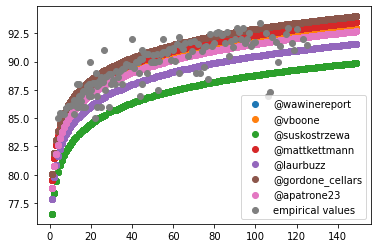

In [ ]:
plt.scatter(prices, wawinereport_ratings, label = '@wawinereport')
plt.scatter(prices, vboone_ratings, label = '@vboone')
plt.scatter(prices, suskostrzewa_ratings, label = '@suskostrzewa')
plt.scatter(prices, mattkettmann_ratings, label = '@mattkettmann')
plt.scatter(prices, laurbuzz_ratings, label = '@laurbuzz')
plt.scatter(prices, gordone_cellars_ratings, label = '@gordone_cellars')
plt.scatter(prices, apatrone23_ratings, label = '@apatrone23')
plt.scatter(price['Price'], price['Rating'], label = 'empirical values')
plt.legend(loc='best')